# Low-SOC Resistance Animation

5/7/2022

Andrew Weng

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from matplotlib import animation, rc
from IPython.display import HTML, Image


import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')
    
    
from src.formation import FormationCell
from src.utils import get_label_registry
from src import stoicmodel

In [2]:
paths = yaml.load(open('paths.yaml', 'r'), Loader=yaml.FullLoader)

In [3]:
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

In [4]:
# Configure plot settings
plt.rc('font', **{'family'     : 'sans-serif',
                  'sans-serif' : ['Arial'],
                  'size': 18
                  })
plt.rc('figure', **{'autolayout' : True,
                    'figsize'    : (7, 5),
                    'facecolor'  : 'white',
                    'dpi'        : 150
                    })
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('axes',  labelsize='medium', grid=False)
plt.rc('axes',  titlesize='medium')
plt.rc('legend', fontsize='medium')

## Configure globals

In [5]:
# Formation types
CELL_BASE = 4 # baseline high temperature
CELL_FAST = 33 # fast formation high temperature

# Some physical limits
MIN_VOLTAGE = 3.0
MAX_VOLTAGE = 4.2

In [6]:
# Plot aesthetics
COLOR_BASE = np.array([0, 0, 0])
COLOR_FAST = np.array([44, 121, 245])/255
COLOR_FAST_RT = np.array([0, 0, 1])
COLOR_FAST_HT = np.array([1, 0, 0])
LINESTYLE_BASE = ':'
LINESTYLE_FAST = '-'

# Pos/neg electrode colors
COLOR_POS = np.array([0, 0, 1])
COLOR_NEG = np.array([1, 0, 0])
COLOR_FULL = np.array([0, 0, 0])

COLOR_BG = (0.2, 0.2, 0.2)
COLOR_REF = (0.7, 0.7, 0.7)

NOMINAL_CAPACITY_AH = 2.36
CAPACITY_LIMITS_AH = (0.8, 2.4)
TARGET_RETENTION = 0.7

figsize = (9, 5.5)

## Get data on cells

In [7]:
# Data from cells

# Initialize a container for formation cell data
cell_dict = dict()
cellid_list = np.arange(1, 41)

for cellid in cellid_list:
    cell_dict[cellid] = FormationCell(cellid)

# Data from HPPC pulses (pre-aggregated)
df_hppc_3 = cell_dict[CELL_BASE].process_diagnostic_hppc_discharge_data()[0]['data']

# Data from the eSOH algorithm results (pre-aggregated)
df_esoh_3 = cell_dict[CELL_BASE].get_esoh_fitting_data()[0] # a fresh dataset

# Summary statistics
summary_stats = cell_dict[CELL_FAST].get_formation_test_summary_statistics()
q_lli_ah_ref = summary_stats['form_first_charge_capacity_ah'] - summary_stats['form_final_discharge_capacity_ah']

In [12]:
fig = plt.figure(figsize=(6,6))


<Figure size 900x900 with 0 Axes>

In [13]:
# initialization function: plot the background of each frame
def init():
    
    
    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    ax2 = plt.gca().twinx()
    
    plt.subplot(2, 1, 2)
    ax3 = plt.gca()
    
    return (ax1, ax2, ax3)

In [14]:
# animation function. This is called sequentially
def animate(i, pos_shrink, neg_shrink, res_orig, metrics_orig, target_soc, min_voltage, max_voltage, xlims):

    l1 = stoicmodel.plot_shift_animate(-i*0.01, pos_shrink, neg_shrink,
               res_orig, metrics_orig, target_soc, min_voltage,
               max_voltage, xlims)
    
    return (l1,)

In [15]:
target_soc = 0.05

res_orig = stoicmodel.fetch_voltage_resistance_dataset(df_esoh_3, df_hppc_3, 
                                            frac_cathode_resistance=0.70,
                                            resistance_curves_type='default',  # default, split, swapped
                                            resistance_interp_kind='cubic')    # linear, cubic

metrics_orig = stoicmodel.compute_useful_metrics(res_orig, MIN_VOLTAGE, MAX_VOLTAGE, target_soc) 

/home/wenga/git-repos/fast-formation/env-form/lib/python3.8/site-packages/matplotlib/lines.py:1157: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  neq = current != val
/home/wenga/git-repos/fast-formation/env-form/lib/python3.8/site-packages/matplotlib/axis.py:124: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if labelcolor == 'inherit':


RuntimeError: The animation function must return a sequence of Artist objects.

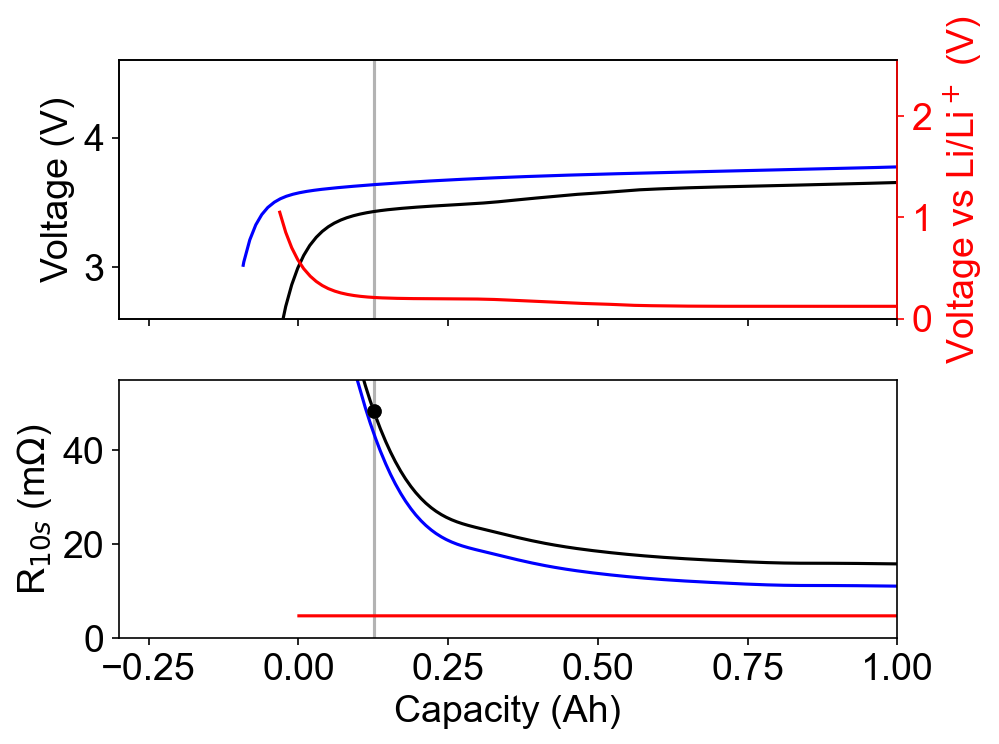

In [16]:
# call the animator. blit=True means only re-draw the parts that 
# have changed.

pos_shrink = 0;
neg_shrink = 0;
xlims = (-0.3, 1)
    
fargs = (pos_shrink, neg_shrink, res_orig, metrics_orig, target_soc, MIN_VOLTAGE, MAX_VOLTAGE, xlims)

anim = animation.FuncAnimation(fig, animate, frames=10, interval=20, blit=True, fargs=fargs)

In [ ]:
anim

In [ ]:
anim.save('animation.gif', writer='imagemagick', fps=60, dpi=50)

Image(url='../../../animation.gif')

